# APLICACIÓN DE LA CIENCIA DE DATOS EN EL DESARROLLO DE UN PRODUCTO DE DATOS PARA LA PREDICCIÓN DEL CONSUMO ENERGÉTICO Y LA ESTIMACIÓN DEL COSTO EN UNA VIVIENDA, QUE PERMITA MEJORAR LA TOMA DE DECISIONES ORIENTADAS A SU SEGUIMIENTO Y CONTROL

## Presentado por:
<ul>
    <li>Aldemar Bernal Hernandez</li>
    <li>Maria Camila Alvarez Perdomo</li>
</ul>


In [1]:
# Librerías Básicas
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

# Modelado y Forecasting

from sklearn.linear_model import Ridge
from lightgbm import LGBMRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregMultiOutput import ForecasterAutoregMultiOutput
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster

In [2]:
# Datasets
file_path = "HomeA/2014/AÑOXTEM.csv"
df = pd.read_csv(file_path)

file_path_2015 = "HomeA/2015/HomeA-meter2_2015.csv"
df2015 = pd.read_csv(file_path_2015)

# Algunas mediciones en minutos
file_path_2016 = "HomeA/2016/HomeA-meter2_2016.csv"
df2016 = pd.read_csv(file_path_2016)

In [3]:
# Tamaños de los datasets sin limpieza
print(df.shape)
print(df2015.shape)
print(df2016.shape)

(17522, 14)
(17522, 14)
(246641, 14)


In [4]:
# Información total del dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17522 entries, 0 to 17521
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Date                     17522 non-null  object 
 1   use [kW]                 17522 non-null  float64
 2   gen [kW]                 17522 non-null  float64
 3   FurnaceHRV [kW]          17522 non-null  float64
 4   CellarOutlets [kW]       17522 non-null  float64
 5   WashingMachine [kW]      17522 non-null  float64
 6   FridgeRange [kW]         17522 non-null  float64
 7   DisposalDishwasher [kW]  17522 non-null  float64
 8   KitchenLights [kW]       17522 non-null  float64
 9   BedroomOutlets [kW]      17522 non-null  float64
 10  BedroomLights [kW]       17522 non-null  float64
 11  MasterOutlets [kW]       17522 non-null  float64
 12  MasterLights [kW]        17522 non-null  float64
 13  DuctHeaterHRV [kW]       17522 non-null  float64
dtypes: float64(13), object

### kWh es una medida de energía, mientras que kW es una medida de potencia eléctrica, para tratar el dataset correctamente debemos transformar las mediciones.
### Debido a que las mediciones se encuentran en kW (Kilovatio), debemos convertirlas a kWh (Kilovatio-hora). El cálculo es el siguiente: 

<center><h1><center>kWh  =   kW  *  h</center></h1>  

#### Donde:
#### kWh es la energía
#### kW es la potencia eléctrica
#### h es el tiempo en horas

In [5]:
# Eliminar kW de los headers junto con las columnas innecesarias 2014
df.columns = [col.replace(' [kW]', '') for col in df.columns]
df = df.rename(columns={'Date': 'Time'})
df.drop(['use', 'gen', 'CellarOutlets', 'BedroomOutlets', 'MasterOutlets'], axis=1, inplace=True)

# Eliminar kW de los headers junto con las columnas innecesarias 2015
df2015.columns = [colum.replace(' [kW]', '') for colum in df2015.columns]
df2015 = df2015.rename(columns={'Date & Time': 'Time'})
df2015.drop(['use', 'gen', 'CellarOutlets', 'BedroomOutlets', 'MasterOutlets'], axis=1, inplace=True)

# Eliminar kW de los headers junto con las columnas innecesarias 2016
df2016.columns = [columnas.replace(' [kW]', '') for columnas in df2016.columns]
df2016 = df2016.rename(columns={'Date & Time': 'Time'})
df2016.drop(['use', 'gen', 'CellarOutlets', 'BedroomOutlets', 'MasterOutlets'], axis=1, inplace=True)

In [6]:
# Conversión del formato fecha, se convierte en datetime.
# Una vez en formato datetime, y para hacer uso de las funcionalidades de pandas, se establece como índice. 
df['Time'] = pd.to_datetime(df['Time'])
df = df.set_index('Time')
df = df.sort_index()

# 2015
df2015['Time'] = pd.to_datetime(df2015['Time'])
df2015 = df2015.set_index('Time')
df2015 = df2015.sort_index()

# 2016
df2016['Time'] = pd.to_datetime(df2016['Time'])
df2016 = df2016.set_index('Time')
df2016 = df2016.sort_index()

In [7]:
# Agregado en intervalos de 1H, se realiza el promedio
df = df.resample(rule='H', closed='left', label ='right').mean()

#2015
df2015 = df2015.resample(rule='H', closed='left', label ='right').mean()

#2016
df2016 = df2016.resample(rule='H', closed='left', label ='right').mean()

In [8]:
# Comando para detectar valors NaN 

# Para el 2014 faltaron los datps de Marzo 9 a las 2-2:30
# Para el 2015 faltaron los datos de Marzo 8 a las 2-2:30
# Para el 2016 faltaron los datos de Marzo 13 a las 2-2:30

# nan_rows = df2016[df2016.isnull().any(1)]
# nan_rows.isnull()

In [9]:
# Tamaños de los datasets sin limpieza
print(df.shape)
print(df2015.shape)
print(df2016.shape)

#2016 tiene más registros porque fue el año bisiesto

(8760, 8)
(8760, 8)
(8784, 8)


In [10]:
# Unir datasets

join = [df, df2015, df2016]
result = pd.concat(join)
result

,FurnaceHRV,WashingMachine,FridgeRange,DisposalDishwasher,KitchenLights,BedroomLights,MasterLights,DuctHeaterHRV
Time,,,,,,,,
2014-01-01 01:00:00,0.188748,0.005683,0.050515,0.005490,0.008677,0.006884,0.010139,0.329129
2014-01-01 02:00:00,0.158467,0.005653,0.048434,0.005477,0.003123,0.004873,0.010089,0.328092
2014-01-01 03:00:00,0.111822,0.005586,0.043357,0.005429,0.003115,0.004841,0.010002,0.325534
2014-01-01 04:00:00,0.068529,0.005560,0.044769,0.005432,0.003131,0.004846,0.010033,0.323582
2014-01-01 05:00:00,0.074540,0.005565,0.044778,0.005469,0.004444,0.004870,0.010085,0.324708
...,...,...,...,...,...,...,...,...
2016-12-31 20:00:00,0.064502,0.000370,0.000995,0.000118,0.000016,0.004667,0.013964,0.000061
2016-12-31 21:00:00,0.094019,0.000468,0.000991,0.000139,0.000017,0.004696,0.014089,0.000067
2016-12-31 22:00:00,0.113943,0.000519,0.000991,0.000154,0.000018,0.004722,0.014261,0.000072


## Análisis Exploratorio de Datos

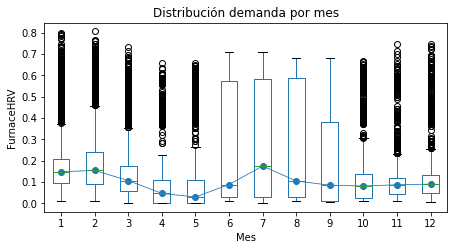

In [11]:
# Comportamiento mensual para FurnaceHRV 

fig, ax = plt.subplots(figsize=(7, 3.5))
result['Mes'] = result.index.month
result.boxplot(column='FurnaceHRV', by='Mes', ax=ax,)
result.groupby('Mes')['FurnaceHRV'].median().plot(style='o-', linewidth=0.8, ax=ax)
ax.set_ylabel('FurnaceHRV')
ax.set_title('Distribución demanda por mes')
fig.suptitle('');

##### Se observa una mayor demanda en los meses de Junio,Julio y Agosto

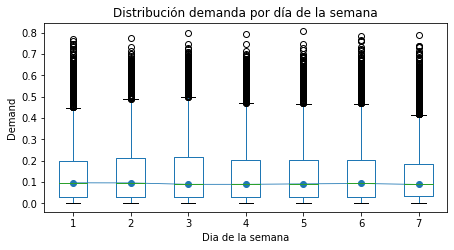

In [12]:
# Comportamiento semanal

fig, ax = plt.subplots(figsize=(7, 3.5))
result['Dia de la semana'] = result.index.day_of_week + 1
result.boxplot(column='FurnaceHRV', by='Dia de la semana', ax=ax)
result.groupby('Dia de la semana')['FurnaceHRV'].median().plot(style='o-', linewidth=0.8, ax=ax)
ax.set_ylabel('Demand')
ax.set_title('Distribución demanda por día de la semana')
fig.suptitle('');

##### Se observa una demanda inferior al comenzar y finalizar la semana

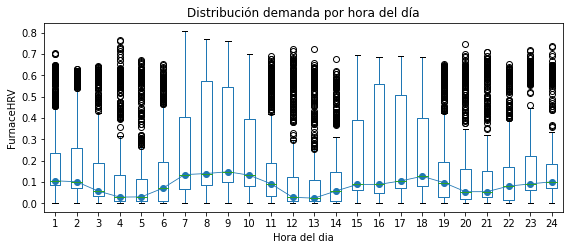

In [13]:
# Gráfico boxplot para estacionalidad diaria

fig, ax = plt.subplots(figsize=(9, 3.5))
result['Hora del dia'] = result.index.hour + 1
result.boxplot(column='FurnaceHRV', by='Hora del dia', ax=ax)
result.groupby('Hora del dia')['FurnaceHRV'].median().plot(style='o-', linewidth=0.8, ax=ax)
ax.set_ylabel('FurnaceHRV')
ax.set_title('Distribución demanda por hora del día')
fig.suptitle('');

##### Se observa que la demanda disminuye entre las 11 A.M - 1 P.M  

## Entrenamiento del Forecaster

#### El proceso de Forecasting consiste en predecir el valor futuro de una serie temporal, sea modelando la serie temporal únicamente en función de su comportamiento pasado (autorregresivo) o empleando otras variables externas a la serie temporal.

In [14]:
# Separación datos train-val-test
result = result.loc['2014-01-01 00:00:00': '2016-12-30 23:00:00']
fin_train = '2015-12-31 23:00:00'
fin_validacion = '2016-11-30 23:00:00'
datos_train = result.loc[: fin_train, :]
datos_val   = result.loc[fin_train:fin_validacion, :]
datos_test  = result.loc[fin_validacion:, :]

print(f"Fechas train      : {datos_train.index.min()} --- {datos_train.index.max()}")
print(f"Fechas validacion : {datos_val.index.min()} --- {datos_val.index.max()}")
print(f"Fechas test       : {datos_test.index.min()} --- {datos_test.index.max()}")

Fechas train      : 2014-01-01 01:00:00 --- 2015-12-31 23:00:00
Fechas validacion : 2015-12-31 23:00:00 --- 2016-11-30 23:00:00
Fechas test       : 2016-11-30 23:00:00 --- 2016-12-30 23:00:00


##### Se crea y entrena un modelo autorregresivo recursivo (ForecasterAutoreg) a partir de un modelo de regresión lineal y una ventana temporal de 24 lags. Esto último significa que, para cada predicción, se utilizan como predictores la demanda de las 24 horas anteriores.

In [15]:
# Crear y entrenar forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                regressor = make_pipeline(StandardScaler(), Ridge()),
                lags      = 24
             )

forecaster.fit(y=result.loc[:fin_validacion, 'FurnaceHRV'])
forecaster

ForecasterAutoreg 
Regressor: Pipeline(steps=[('standardscaler', StandardScaler()), ('ridge', Ridge())]) 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24] 
Window size: 24 
Included exogenous: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [Timestamp('2014-01-01 01:00:00'), Timestamp('2016-11-30 23:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: H 
Regressor parameters: {'standardscaler__copy': True, 'standardscaler__with_mean': True, 'standardscaler__with_std': True, 'ridge__alpha': 1.0, 'ridge__copy_X': True, 'ridge__fit_intercept': True, 'ridge__max_iter': None, 'ridge__normalize': 'deprecated', 'ridge__positive': False, 'ridge__random_state': None, 'ridge__solver': 'auto', 'ridge__tol': 0.001} 
Creation date: 2022-11-29 22:32:11 
Last fit date: 2022-11-29 22:32:11 
Skforecast version: 0.4.2 

##### A este tipo de evaluación se le conoce como backtesting, y puede aplicarse fácilmente con la función backtesting_forecaster() para un lapso de tiempo predefinido por nosotros, en este caso entre 2014-01-01 05:00:00 y 2014-11-30 23:00:00 y predecir las siguientes 24 horas . Esta función devuelve, además de las predicciones, una métrica de error.

In [16]:
# Backtest

metrica, predicciones = backtesting_forecaster(
                            forecaster = forecaster,
                            y          = result.FurnaceHRV,
                            initial_train_size = len(result.loc[:fin_validacion]),
                            steps      = 24,
                            metric     = 'mean_absolute_error',
                            refit      = False,
                            verbose    = True
                        )

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 25559
Number of observations used for backtesting: 720
    Number of folds: 30
    Number of steps per fold: 24

Data partition in fold: 0
    Training:   2014-01-01 01:00:00 -- 2016-11-30 23:00:00
    Validation: 2016-12-01 00:00:00 -- 2016-12-01 23:00:00
Data partition in fold: 1
    Training:   2014-01-01 01:00:00 -- 2016-11-30 23:00:00
    Validation: 2016-12-02 00:00:00 -- 2016-12-02 23:00:00
Data partition in fold: 2
    Training:   2014-01-01 01:00:00 -- 2016-11-30 23:00:00
    Validation: 2016-12-03 00:00:00 -- 2016-12-03 23:00:00
Data partition in fold: 3
    Training:   2014-01-01 01:00:00 -- 2016-11-30 23:00:00
    Validation: 2016-12-04 00:00:00 -- 2016-12-04 23:00:00
Data partition in fold: 4
    Training:   2014-01-01 01:00:00 -- 2016-11-30 23:00:00
    Validation: 2016-12-05 00:00:00 -- 2016-12-05 23:00:00
Data partition in fold: 5


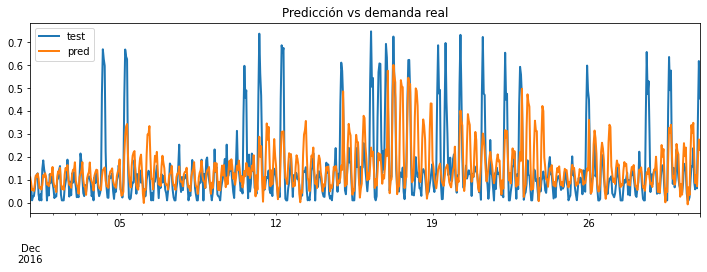

In [17]:
# Gráfico

fig, ax = plt.subplots(figsize=(12, 3.5))
result.loc[predicciones.index, 'FurnaceHRV'].plot(ax=ax, linewidth=2, label='test')
predicciones.plot(linewidth=2, label='predicción', ax=ax)
ax.set_title('Predicción vs demanda real')
ax.legend();

#### En el objeto ForecasterAutoreg entrenado, se han utilizado los primeros 24 lags y un modelo Ridge con los hiperparámetros por defecto. Sin embargo, no hay ninguna razón por la que estos valores sean los más adecuados.

#### Con el objetivo de identificar la mejor combinación de lags e hiperparámetros, se recurre a un Grid Search. Este proceso consiste en entrenar un modelo con cada combinación de hiperparámetros y lags, y evaluar su capacidad predictiva mediante backtesting. En el proceso de búsqueda, es importante evaluar los modelos utilizando únicamente los datos de validación y no incluir los de test, estos se utilizan solo en último lugar para evaluar al modelo final.

In [18]:
# Error backtest
# ==============================================================================
print(f'Error backtest: {metrica}')

Error backtest: [0.08596362]


In [19]:
# Grid search de hiperparámetros
# ==============================================================================
forecaster = ForecasterAutoreg(
                    regressor = make_pipeline(StandardScaler(), Ridge()),
                    lags      = 24 # Este valor será remplazado en el grid search
              )

# Hiperparámetros del regresor
param_grid = {'ridge__alpha': np.logspace(-3, 5, 10)}

# Lags utilizados como predictores
lags_grid = [5, 24, [1, 2, 3, 23, 24, 25, 47, 48, 49]]

resultados_grid = grid_search_forecaster(
                        forecaster  = forecaster,
                        y           = result.loc[:fin_validacion, 'FurnaceHRV'],
                        param_grid  = param_grid,
                        lags_grid   = lags_grid,
                        steps       = 24,
                        metric      = 'mean_absolute_error',
                        refit       = False,
                        initial_train_size = len(result[:fin_train]),
                        return_best = True,
                        verbose     = False
                  )

loop param_grid:   0%|                                             | 0/10 [00:00<?, ?it/s]

Number of models compared: 30



loop lags_grid: 100%|███████████████████████████████████████| 3/3 [00:54<00:00, 18.13s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24] 
  Parameters: {'ridge__alpha': 0.001}
  Backtesting metric: 0.08913098463142398



In [20]:
# Resultados Grid Search
# ==============================================================================
resultados_grid

,lags,params,metric,ridge__alpha
10,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",{'ridge__alpha': 0.001},0.089131,0.001000
11,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",{'ridge__alpha': 0.007742636826811269},0.089131,0.007743
12,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",{'ridge__alpha': 0.05994842503189409},0.089131,0.059948
13,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",{'ridge__alpha': 0.46415888336127775},0.089131,0.464159
14,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",{'ridge__alpha': 3.593813663804626},0.089134,3.593814
15,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",{'ridge__alpha': 27.825594022071257},0.089153,27.825594
16,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",{'ridge__alpha': 215.44346900318823},0.089316,215.443469
17,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",{'ridge__alpha': 1668.1005372000557},0.090855,1668.100537
27,"[1, 2, 3, 23, 24, 25, 47, 48, 49]",{'ridge__alpha': 1668.1005372000557},0.091978,1668.100537
26,"[1, 2, 3, 23, 24, 25, 47, 48, 49]",{'ridge__alpha': 215.44346900318823},0.092018,215.443469


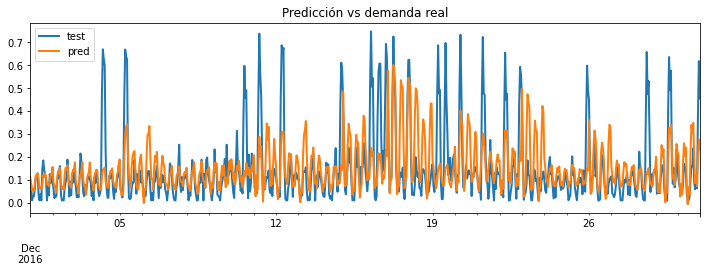

In [21]:
# Backtest modelo final
# ==============================================================================
metrica, predicciones = backtesting_forecaster(
                            forecaster = forecaster,
                            y          = result.FurnaceHRV,
                            initial_train_size = len(result[:fin_validacion]),
                            steps      = 24,
                            metric     = 'mean_absolute_error',
                            refit      = False,
                            verbose    = False
                        )


fig, ax = plt.subplots(figsize=(12, 3.5))
result.loc[predicciones.index, 'FurnaceHRV'].plot(linewidth=2, label='test', ax=ax)
predicciones.plot(linewidth=2, label='predicción', ax=ax)
ax.set_title('Predicción vs demanda real')
ax.legend();

In [22]:
# Backtest del conjunto de test con intervalos de predicción
# ==============================================================================
metric, predicciones = backtesting_forecaster(
                            forecaster          = forecaster,
                            y                   = result.FurnaceHRV,
                            initial_train_size  = len(result.FurnaceHRV[:fin_validacion]),
                            steps               = 24,
                            metric              = 'mean_absolute_error',
                            interval            = [10, 90],
                            n_boot              = 500,
                            in_sample_residuals = True,
                            verbose             = False
                       )

print('Métrica backtesting:', metric)
predicciones.head(739)

Métrica backtesting: [0.08596579]


,pred,lower_bound,upper_bound
2016-12-01 00:00:00,0.110893,0.055385,0.187016
2016-12-01 01:00:00,0.086053,-0.023536,0.213913
2016-12-01 02:00:00,0.053706,-0.071003,0.222911
2016-12-01 03:00:00,0.059125,-0.088554,0.213072
2016-12-01 04:00:00,0.051142,-0.082559,0.198351
...,...,...,...
2016-12-30 19:00:00,0.120270,-0.032957,0.308175
2016-12-30 20:00:00,0.071838,-0.090193,0.259251
2016-12-30 21:00:00,0.189957,0.035730,0.362229
2016-12-30 22:00:00,0.275880,0.133413,0.453969


In [23]:
df_prediccion = pd.DataFrame(predicciones);

In [24]:
# Transformación para sacar el consumo mensual
df_estimarPrecio = df_prediccion.resample('M').sum()
df_estimarPrecio

,pred,lower_bound,upper_bound
2016-12-31,108.336515,11.599444,228.623665


In [25]:
# Estimación de precio total con predicción obtenida
op = round(df_estimarPrecio.iloc[0]['pred'] * 524.86)
currency = "${:,}".format(op)
print('El precio estimado de consumo en el aire acondicionado para el mes de Diciembre es de: ', currency)

El precio estimado de consumo en el aire acondicionado para el mes de Diciembre es de:  $56,862
